In [1]:
%load_ext autoreload
%autoreload 2

import requests
import numpy as np
from sklearn.model_selection import train_test_split
import pandas as pd
import tqdm
from IPython.display import Image, display
import matplotlib.pyplot as plt

## A. Fetch dataset, split into dev and test

In [2]:
link = "http://lib.stat.cmu.edu/datasets/boston"
raw_text = requests.get(link).text # get the raw text
raw_text = raw_text.split('\n') # split into lines
headers = raw_text[7:21]
headers = [h.split()[0] for h in headers]
raw_text = raw_text[22:-1] # discard description

raw_data = []
for i in range(0, len(raw_text), 2):
    # each row is split into 2 lines, so join them first
    row = raw_text[i] + raw_text[i+1]
    raw_data.append(row)

# split each row into columns and convert each cell -> string to float
raw_data = [[float(column) for column in row.split()] for row in raw_data]
raw_data = np.array(raw_data) # no error => equal length rows, error-free import

In [3]:
# 1/6 parts in test, 5/6 parts in dev for 5-fold cross validation later
# random seed set for reproducibility
raw_dev_data, raw_test_data = train_test_split(raw_data, test_size=1/6, random_state=10)
raw_dev_df = pd.DataFrame(raw_dev_data,columns=headers)

## B. Visualise simple statistics, histograms and diversity

In [4]:
raw_dev_df.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
count,421.000000,421.000000,421.000000,421.000000,421.000000,421.000000,421.000000,421.00000,421.000000,421.000000,421.000000,421.000000,421.000000,421.000000
mean,3.864835,11.178147,11.395606,0.066508,0.556202,6.239606,69.111876,3.80733,9.767221,413.133017,18.554632,353.513088,12.997387,21.804276
std,9.170657,23.555059,6.903976,0.249465,0.116732,0.667412,27.880585,2.13385,8.836772,171.026499,2.136945,95.672303,7.087777,8.662466
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.13700,1.000000,187.000000,12.600000,0.320000,1.920000,5.000000
25%,0.082210,0.000000,5.190000,0.000000,0.449000,5.876000,45.700000,2.06510,4.000000,280.000000,17.400000,374.560000,7.430000,16.500000
50%,0.253870,0.000000,9.900000,0.000000,0.538000,6.167000,77.000000,3.26280,5.000000,334.000000,19.100000,391.270000,11.660000,20.700000
75%,3.849700,12.500000,18.100000,0.000000,0.631000,6.565000,94.500000,5.11800,24.000000,666.000000,20.200000,396.210000,17.210000,24.500000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.12650,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


/home/deepan/anaconda3/envs/das_tempchef/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:331: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


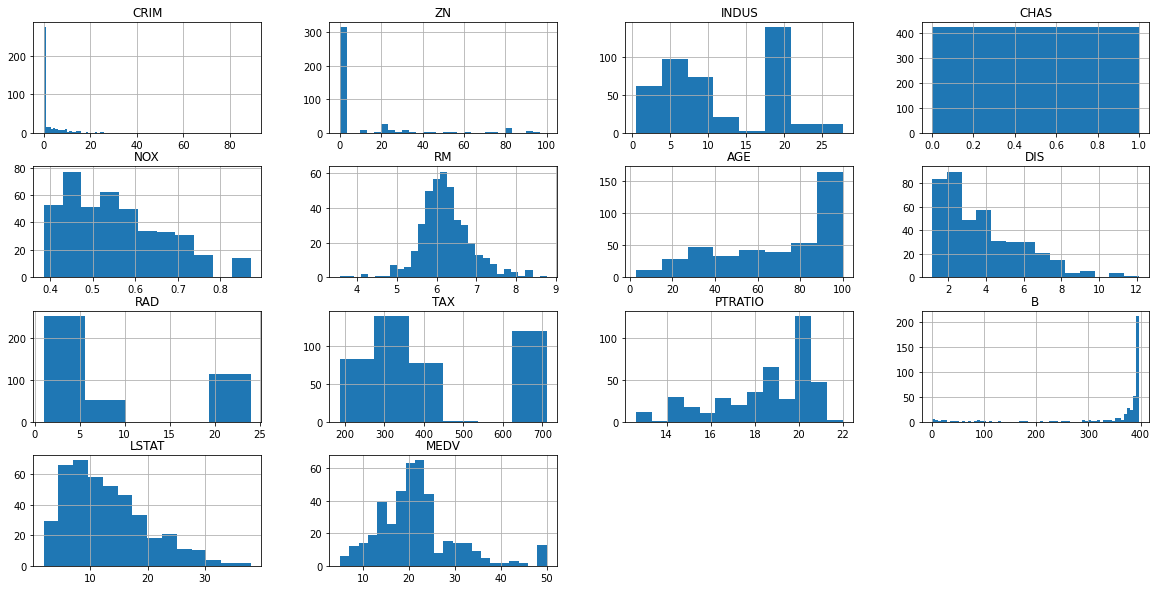

In [5]:
# Freedman Diaconis for bin edges is robust to outliers
# and determines bin numbers/widths according to distribution
hist = raw_dev_df.hist(bins='fd', figsize=(20,10))

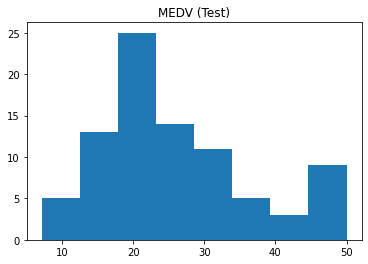

In [6]:
plt.hist(raw_test_data[:,-1],bins='fd'); plt.title('MEDV (Test)'); plt.show()

The distribution of targets in the test set appear similar to the dev distribution.

In [7]:
print('There are <count> unique values in <feature>')
print(len(pd.unique(raw_dev_df['INDUS'])), 'INDUS')
print(len(pd.unique(raw_dev_df['CHAS'])), 'CHAS')
print(len(pd.unique(raw_dev_df['RAD'])), 'RAD')
print(len(pd.unique(raw_dev_df['TAX'])), 'TAX')

print('\n Values in RAD are ', pd.unique(raw_dev_df['RAD']))

There are <count> unique values in <feature>
73 INDUS
2 CHAS
9 RAD
63 TAX

 Values in RAD are  [ 1.  4.  5. 24.  2.  8.  6.  7.  3.]


## D. Visualise correlation matrix

In [8]:
rho_mat = raw_dev_df.corr()
rho_mat.style.background_gradient(vmin=-1, vmax=+1, cmap='coolwarm')

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
CRIM,1.000000,-0.196326,0.391956,-0.057702,0.414182,-0.205530,0.351631,-0.379446,0.613703,0.569235,0.279420,-0.372585,0.439895,-0.397463
ZN,-0.196326,1.000000,-0.538815,-0.049833,-0.516129,0.337935,-0.574641,0.661702,-0.308551,-0.318727,-0.402924,0.179437,-0.424803,0.405141
INDUS,0.391956,-0.538815,1.000000,0.063499,0.759945,-0.399829,0.655406,-0.725246,0.585722,0.709278,0.377643,-0.355342,0.611618,-0.501573
CHAS,-0.057702,-0.049833,0.063499,1.000000,0.097407,0.083343,0.096319,-0.102296,-0.001601,-0.029059,-0.113577,0.054563,-0.038427,0.154890
NOX,0.414182,-0.516129,0.759945,0.097407,1.000000,-0.319868,0.734237,-0.774971,0.603406,0.659946,0.182835,-0.381993,0.604911,-0.452804
RM,-0.205530,0.337935,-0.399829,0.083343,-0.319868,1.000000,-0.268796,0.222802,-0.198183,-0.285713,-0.323798,0.095755,-0.592136,0.662315
AGE,0.351631,-0.574641,0.655406,0.096319,0.734237,-0.268796,1.000000,-0.753635,0.452864,0.507927,0.273606,-0.281659,0.635140,-0.415051
DIS,-0.379446,0.661702,-0.725246,-0.102296,-0.774971,0.222802,-0.753635,1.000000,-0.498932,-0.546980,-0.242830,0.298644,-0.519843,0.285068
RAD,0.613703,-0.308551,0.585722,-0.001601,0.603406,-0.198183,0.452864,-0.498932,1.000000,0.908873,0.460533,-0.440416,0.468480,-0.381548
TAX,0.569235,-0.318727,0.709278,-0.029059,0.659946,-0.285713,0.507927,-0.546980,0.908873,1.000000,0.454927,-0.438759,0.531763,-0.471282


## E. Observations

#### Target
$MEDV$ is chosen as the target, as is more popular among projects using this dataset. Since the values are clipped at 50, the targets in the test set can never be OOD (out-of-distribution). The clipping also explains why it deviates from the usual Gaussian distribution in the last bin.

#### Feature vs Target

The correlations are discussed in pages 96-97 (as printed, alternatively pages 16-17 of the pdf viewer) of the dataset paper at
https://deepblue.lib.umich.edu/bitstream/handle/2027.42/22636/0000186.pdf?sequence=1. Those observations are not repeated here. It should be noted that the observed correlations of $DIS$ and $RAD$ with the target differ from the expected correlations.
    
* $CRIM$ has very high kurtosis and skewness in the [0,1] bin. Explore if clipping (outlier removal) can improve performance. - __Exp 1__
* $ZN$ has most values at exactly 0, while the rest are non-zero. Explore if transforming to binary categorical improves performance. - __Exp 2__
* $CHAS$ is uncorrelated with all other variables as well as the target. However, this poor correlation does not justify dropping the feature. It may have been caused by $CHAS$ being a categorical variable.
* $RAD$ has only 9 unique values, which do not change smoothly (1,2,..8,24). It is ideal for transforming to a categorical variable.
* $B$ has been supplied with a quadratic transformation in the form $B = (B'-0.63)^2$. Explore if undoing it improves performance - __Exp 3__
* $B$ also has a high skewnwss and kurtosis in the last bin. Explore if transforming it to a binary categorical variable improves performance - __Exp 4__
* Non-linear transformations are recommended for $RM$ (-> $RM^2$), $DIS$ (-> $log(DIS)$), $RAD$ (-> $log(RAD)$) and $LSTAT$ (-> $log(LSTAT)$). However, the recommendations are for linear regression. Since we plan to use a Random Forest regressor, these recommendations are ignored.

#### Feature vs Feature

* $RAD$ and $TAX$ are highly correlated, while having similar correlations with the target and other variables. One of them can be dropped from the final model - __Exp 5__
* It is simple to explain most correlations. For example, $DIS$ and $NOX$ are highly negatively correlated. This is because pollution levels tend to be higher near highly industrialized parts of a city, where the distance to employment centers would be low.
* Some unexpected correlations can be explained by underlying variables. For example, $TAX$ and $NOX$ are highly correlated, with no obvious cause-effect relationship. But, both those factors are affected by location with respect to highways ($RAD$), which leads to an apparent high correlation.
* Some correlations need additional considerations and further study or domain knowledge before they can be explained. They are beyond the scope of the given data. Such an example is the correlation between $DIS$ and $ZN$.

## F. Experiments

Random Forest regression is used in all experiments.
* It can model non-linear relationships
* It can handle categorical data
* Data does not need to be standardised/normalised
* Target values will not be OOD
* Overfitting can be controlled for easily by changing the number of Decision Trees (as a first experiment, while other hyper-parameters are also available for fine-tuning)

To track and compare the performance across experiments, we will be using the following metrics:
* Mean Square Error (MSE) between predicted and ground truth target values
* Correlation Co-efficient (RHO) between the same, to check if the model is at least learning the trend in the data

Other implementation details:
* 5-fold cross validation will be used in every experiment
* $RAD$ will be converted to dummy categorical variables (1-hot vectors) for all experiments
* All hyper-parameters for the Random Forest will be kept constant for now, to enable fair comparison among experiments

#### Transform RAD to 1-hot

In [9]:
rad_cat = pd.get_dummies(raw_dev_df['RAD'], prefix='RAD_')
raw_dev_df = raw_dev_df.drop('RAD', axis=1)
raw_dev_df = rad_cat.join(raw_dev_df)

## Exp 0

Baseline experiment, where all features are fed as is to a Random Forest regression model.